In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

### Lasso

In [37]:
np.random.seed(42)

num_samples = 1000
num_features = 5

x = np.random.randn(num_samples, num_features)

true_coefficients = np.array([1.5, -2.0, 0.7] + [0] * (num_features - 3))

noise = np.random.randn(num_samples) * 0.5

y = np.dot(x, true_coefficients) + noise

In [38]:
class LassoRegression:
    def __init__(self, alpha=1.0, max_iter=1000, tol=1e-4):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.bias_ = 0

        for _ in range(self.max_iter):
            coef_old = self.coef_.copy()

            for j in range(n_features):
                X_j = X[:, j]
                y_pred = self.predict(X)
                r = y - y_pred + self.coef_[j] * X_j
                z = np.sum(X_j * r) / n_samples

                if z < -self.alpha:
                    self.coef_[j] = (z + self.alpha) / np.sum(X_j**2) * n_samples
                elif z > self.alpha:
                    self.coef_[j] = (z - self.alpha) / np.sum(X_j**2) * n_samples
                else:
                    self.coef_[j] = 0

            self.bias_ = np.mean(y - np.dot(X, self.coef_))

            if np.sum((self.coef_ - coef_old) ** 2) < self.tol:
                break

    def predict(self, X):
        return np.dot(X, self.coef_) + self.bias_

In [45]:
my_lasso_lr = LassoRegression(alpha=0.1)
lasso_lr = Lasso(alpha=0.1)

my_lasso_lr.fit(x, y)
lasso_lr.fit(x, y)

print("My Lasso Regression Coefficients:", my_lasso_lr.coef_)
print("Lasso Regression Coefficients:", lasso_lr.coef_)

My Lasso Regression Coefficients: [ 1.40123987 -1.89496953  0.59156337  0.          0.        ]
Lasso Regression Coefficients: [ 1.40123992 -1.89496952  0.59156337  0.          0.        ]


In [9]:
lr = LinearRegression()
lr.fit(x, y)
print("Linear Regression Coefficients:", lr.coef_)

Linear Regression Coefficients: [ 1.49384306e+00 -1.98712331e+00  6.84402842e-01  6.20174668e-04
  2.02168948e-02]


### Ridge

In [50]:
class RidgeRegression:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X = np.hstack((np.ones((n_samples, 1)), X))

        A = np.dot(X.T, X) + self.alpha * np.eye(n_features + 1)
        b = np.dot(X.T, y)

        params = np.linalg.solve(A, b)
        self.intercept_ = params[0]
        self.coef_ = params[1:]

    def predict(self, X):
        y_pred = np.dot(X, self.coef_) + self.intercept_
        return y_pred

In [96]:
from sklearn.model_selection import train_test_split

n_samples = 1000
n_features = 5

X = np.random.normal(loc=0, scale=1, size=(n_samples, 1))
for i in range(1, n_features):
    X = np.column_stack(
        (X, X[:, 0] + np.random.normal(loc=0, scale=0.1, size=n_samples))
    )

y = np.sum(X, axis=1) + np.random.normal(loc=0, scale=1, size=n_samples)

data = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(n_features)])
data["y"] = y

train, test = train_test_split(data, test_size=0.2, random_state=42)

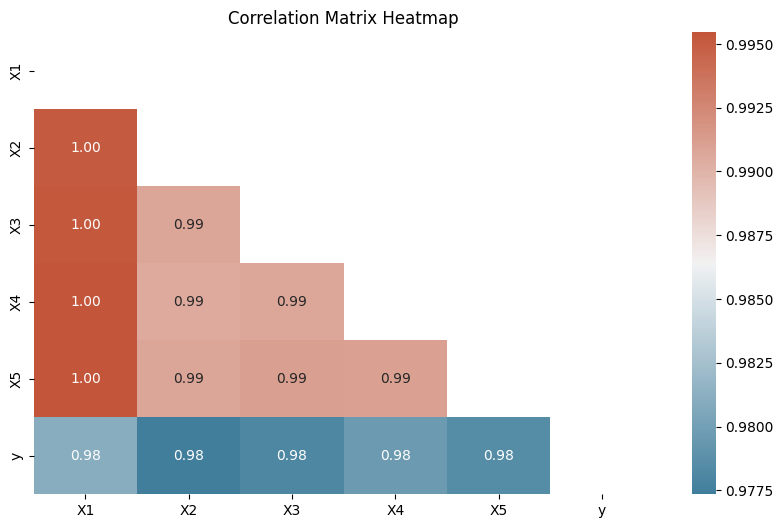

In [97]:
import seaborn as sns

plt.figure(figsize=(10, 6))
corr_matrix = train.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [98]:
X_train = train[["X1", "X2", "X3", "X4", "X5"]]
y_train = train["y"]
X_test = test[["X1", "X2", "X3", "X4", "X5"]]
y_test = test["y"]

In [115]:
my_ridge_lr = RidgeRegression()
ridge_lr = Ridge()


my_ridge_lr.fit(X_train, y_train)
ridge_lr.fit(X_train, y_train)
lr.fit(X_train, y_train)

print("My Ridge Regression Coefficients:", my_ridge_lr.coef_)
print("Ridge Regression Coefficients:", ridge_lr.coef_)
print("Linear Regression Coefficients:", lr.coef_)

My Ridge Regression Coefficients: [1.05859922 0.55954665 0.84375988 1.62293226 0.95320798]
Ridge Regression Coefficients: [1.05858492 0.55955682 0.84375847 1.62293407 0.95321255]
Linear Regression Coefficients: [1.08063701 0.49942862 0.81985768 1.69739303 0.94149193]


In [116]:
from sklearn.metrics import mean_squared_error

pred_lr = lr.predict(X_test)
pred_ridge = ridge_lr.predict(X_test)

mean_squared_error(y_test, pred_lr), mean_squared_error(y_test, pred_ridge)

(0.8902453364991371, 0.8873122859207447)

### ElasticNet

In [144]:
class MyElasticNet:
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=1000, tol=1e-4, lr=0.01):
        self.alpha = alpha  # Общий коэффициент регуляризации
        self.l1_ratio = l1_ratio  # Доля L1 регуляризации в общем коэффициенте
        self.max_iter = max_iter  # Максимальное количество итераций
        self.tol = tol  # Точность для остановки алгоритма
        self.lr = lr  # Шаг обучения (learning rate)
        self.coef_ = None  # Коэффициенты модели
        self.intercept_ = None  # Свободный член в уравнении модели

    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        n, m = X.shape

        w = np.zeros(m)

        for _ in range(self.max_iter):
            y_pred = X @ w
            gradient = X.T @ (y_pred - y) / n  # Градиент MSE

            w_prev = w.copy()
            w = self._update_weights(w, gradient, self.alpha, self.l1_ratio, self.lr)

            if np.linalg.norm(w - w_prev, ord=1) < self.tol:
                break

        self.intercept_ = w[0]
        self.coef_ = w[1:]
        return self

    def _update_weights(self, w, gradient, alpha, l1_ratio, lr):
        """Обновление весов с учетом L1 и L2 регуляризации"""
        l1 = alpha * l1_ratio
        l2 = alpha * (1 - l1_ratio)

        w -= lr * gradient

        w *= 1 - lr * l2

        w = np.sign(w) * np.maximum(np.abs(w) - lr * l1, 0)
        return w

    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return X @ np.concatenate([[self.intercept_], self.coef_])

In [145]:
en_lr = ElasticNet(alpha=0.1, l1_ratio=0.1)
my_en_lr = MyElasticNet(alpha=0.1, l1_ratio=0.1)

my_en_lr.fit(X_train, y_train)
en_lr.fit(X_train, y_train)
lr.fit(X_train, y_train)

print("My Elastic Net Regression Coefficients:", my_en_lr.coef_)
print("Elastic Net Regression Coefficients:", en_lr.coef_)
print("Linear Regression Coefficients:", lr.coef_)

My Elastic Net Regression Coefficients: [0.99155294 0.97267002 0.98102873 1.01559467 0.98449511]
Elastic Net Regression Coefficients: [0.99281025 0.9387651  0.96945455 1.06272123 0.98174043]
Linear Regression Coefficients: [1.08063701 0.49942862 0.81985768 1.69739303 0.94149193]


### Poly

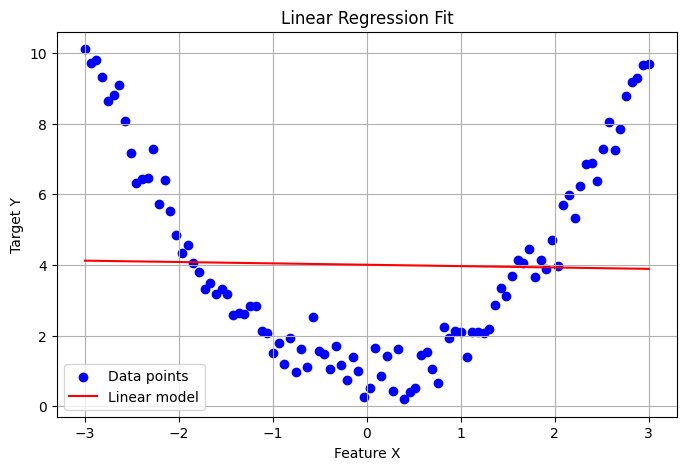

In [164]:
x = np.linspace(-3, 3, 100)
y = 1 + x**2 + np.random.normal(0, 0.5, size=x.size)
X = x[:, np.newaxis]
lr.fit(X, y)

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color="blue", label="Data points")
y_pred_linear = lr.predict(X)

plt.plot(x, y_pred_linear, color="red", label="Linear model")
plt.title("Linear Regression Fit")
plt.xlabel("Feature X")
plt.ylabel("Target Y")
plt.legend()
plt.grid(True)
plt.show()

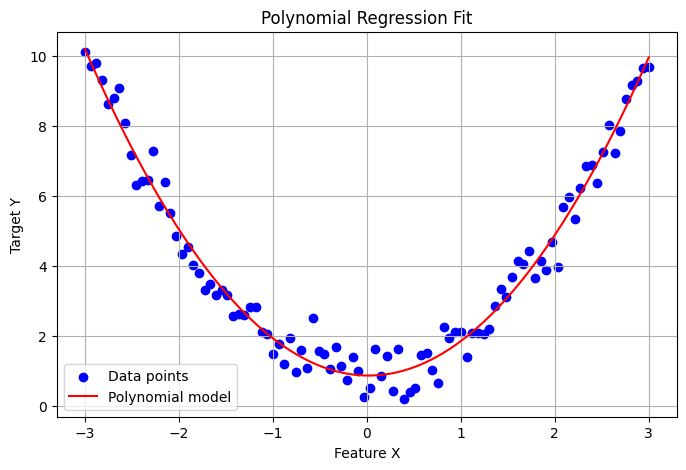

In [165]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(x.reshape(-1, 1))
lr.fit(X_poly, y)

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color="blue", label="Data points")

y_pred = lr.predict(X_poly)

plt.plot(x, y_pred, color="red", label="Polynomial model")
plt.title("Polynomial Regression Fit")
plt.xlabel("Feature X")
plt.ylabel("Target Y")
plt.legend()
plt.grid(True)
plt.show()

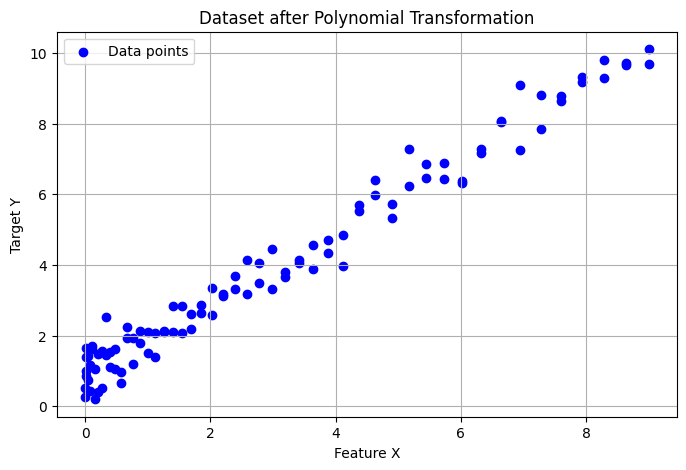

In [169]:
new_x = [i[2] for i in X_poly]

plt.figure(figsize=(8, 5))
plt.scatter(new_x, y, color="blue", label="Data points")
plt.title("Dataset after Polynomial Transformation")
plt.xlabel("Feature X")
plt.ylabel("Target Y")
plt.legend()
plt.grid(True)
plt.show()

### Anomaly

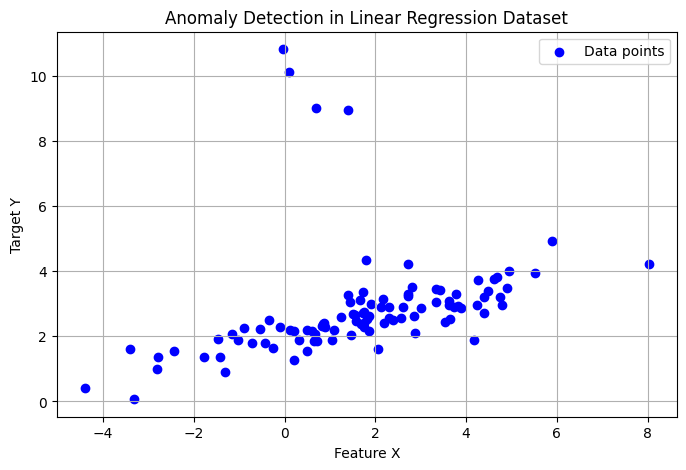

In [173]:
x = 2.5 * np.random.randn(100) + 1.5
res = 0.5 * np.random.randn(100)
y = 2 + 0.3 * x + res

x[95:99] = 1 + np.random.randn(4)
y[95:99] = 10 + np.random.randn(4)

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color="blue", label="Data points")
plt.title("Anomaly Detection in Linear Regression Dataset")
plt.xlabel("Feature X")
plt.ylabel("Target Y")
plt.legend()
plt.grid(True)
plt.show()

### Условия применимости

- Линейность отношений: Взаимосвязь между зависимыми и независимыми переменными должна быть линейной (Коэффицент корреляции пирсона: Поможет выявить линейную связь).

- Независимость ошибок: Ошибки (( \epsilon )) должны быть независимы друг от друга (Тест Дарбина-Уотсона: Проверяет независимость ошибок.).

- Гомоскедастичность: Дисперсия ошибок должна быть постоянной для всех уровней предсказаний.(График остатков: Помогает выявить негомоскедастичность и ненормальность ошибок).

- Отсутствие мультиколлинеарности: Независимые переменные не должны быть сильно коррелированы между собой(Фактор инфляции дисперсии (VIF): Оценивает степень мультиколлинеарности между предикторами).

- Нормальность ошибок: Распределение ошибок должно быть нормальным(Q-Q plot: Проверяет нормальность распределения остатков).

### Гомоскедастичность — одно из условий эффективности регрессионной модели. В статистике последовательность или вектор случайных величин являются гомоскедастичными, если все случайные величины в последовательности или векторе имеют одинаковую дисперсию.


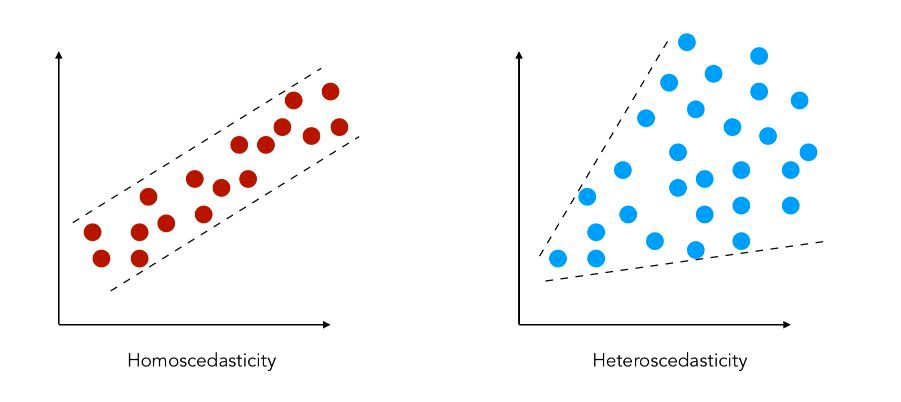